# Код реалізації та результати роботи до завдання 3
Import libraries

In [13]:
from scipy.special import expit
import numpy as np
from sklearn.metrics import accuracy_score
from IPython.display import Image

from labs.helpers import read_dataset

Prepare to load data

In [14]:
data_dir = "../../data/train"
classes = ["field", "water"]
file_pattern = "*{}*.jpg"
standard_shape = (50, 50, 3)

Load data and split it to train and test datasets

In [15]:
dataset, features = read_dataset(data_dir, classes, file_pattern, standard_shape)
train_df = dataset.sample(frac=0.8, random_state=18)
test_df = dataset.drop(train_df.index)

Demonstrate datasets

In [16]:
train_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
0,0.0,7.0,3.0,11.0,24.0,15.0,0.0,10.0,0.0,10.0,...,156.0,199.0,143.0,152.0,192.0,129.0,157.0,197.0,134.0,field
13,48.0,83.0,76.0,51.0,86.0,79.0,55.0,90.0,83.0,54.0,...,52.0,85.0,74.0,61.0,94.0,85.0,59.0,92.0,83.0,water
18,58.0,92.0,91.0,61.0,95.0,94.0,67.0,101.0,100.0,73.0,...,73.0,103.0,95.0,87.0,115.0,103.0,86.0,114.0,102.0,water
12,61.0,87.0,74.0,70.0,96.0,83.0,80.0,107.0,90.0,94.0,...,97.0,129.0,106.0,91.0,120.0,102.0,91.0,120.0,102.0,water
7,126.0,168.0,102.0,125.0,168.0,99.0,123.0,166.0,97.0,123.0,...,175.0,196.0,119.0,181.0,197.0,122.0,181.0,197.0,122.0,field


In [17]:
test_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
5,196.0,207.0,131.0,194.0,205.0,129.0,190.0,200.0,127.0,186.0,...,174.0,186.0,114.0,174.0,192.0,116.0,174.0,192.0,116.0,field
10,212.0,217.0,161.0,214.0,219.0,163.0,212.0,220.0,163.0,204.0,...,146.0,190.0,103.0,150.0,194.0,105.0,150.0,194.0,105.0,field
17,66.0,105.0,86.0,64.0,103.0,84.0,62.0,101.0,82.0,59.0,...,153.0,173.0,88.0,120.0,143.0,99.0,87.0,110.0,66.0,water
19,55.0,87.0,82.0,54.0,86.0,81.0,53.0,85.0,80.0,53.0,...,178.0,196.0,114.0,173.0,192.0,113.0,158.0,177.0,98.0,water


Python class that realizes learning and prediction operations

In [18]:
class LinearPerceptron:

    __features = None
    __class_to_number = None
    __number_to_class = None
    weights = None
    __old_weights_delta = None

    def __init__(self, learning_rate=5, moment=0.7, max_epoch=100000):
        self.__learning_rate = learning_rate
        self.__moment = moment
        self.__max_epoch = max_epoch
        self.__activation = expit

    def fit(self, df, train_features, target):
        self.__features = train_features
        self.__build_classes_binarizers(df, target)
        train_values = self.__build_values(df)
        binarized_classes = df[target].apply(lambda class_: self.__class_to_number[class_]).values.astype("float32")
        self.__old_weights_delta = np.zeros(train_values.shape[1])
        self.weights = np.full(train_values.shape[1], 0.001)
        # inside for operator
        for epoch_number in range(self.__max_epoch):
            cum_error = 0
            for measure_index in range(train_values.shape[0]):
                measure = train_values[measure_index]
                real_value = binarized_classes[measure_index]
                cum_error += self.__learn(measure, real_value)
                mean_epoch_error = np.mean(cum_error)
                if mean_epoch_error < 0.000000001:
                    return

    def __build_values(self, df):
        measures = df[self.__features].values
        bias_neuron_vals = np.ones((measures.shape[0], 1))
        values = np.hstack((bias_neuron_vals, self.__activation(measures)))
        return values

    def __learn(self, measure, real_value):
        neuron_output = self.__go_forward(measure)
        self.__go_backward(measure, neuron_output, real_value)
        return self.__go_forward(measure)

    def __go_forward(self, measure):
        multiplied = np.multiply(measure, self.weights)
        neuron_input = np.sum(multiplied)
        neuron_output = self.__activation(neuron_input)
        return neuron_output

    def __go_backward(self, measure, neuron_output, real_value):
        out_neuron_error = (real_value - neuron_output) * self.__activation_derivative(neuron_output)
        neuron_activation_derivation = np.multiply(1 - measure, measure)
        error_by_weights = out_neuron_error * self.weights
        in_neurons_errors = np.multiply(neuron_activation_derivation, error_by_weights)
        gradients = np.multiply(in_neurons_errors, measure)
        new_weights_delta = self.__learning_rate * gradients + self.__old_weights_delta * self.__moment
        self.weights += new_weights_delta
        self.__old_weights_delta = new_weights_delta

    def __build_classes_binarizers(self, df, target):
        self.__class_to_number = dict()
        self.__number_to_class = dict()
        classes_list = df[target].unique()
        for k, v in enumerate(classes_list[:2]):
            self.__class_to_number[v] = k
            self.__number_to_class[k] = v

    @staticmethod
    def __activation_derivative(neuron_out):
        return (1 - neuron_out) * neuron_out

    def predict(self, df):

        def iterate_over_measures(measure):
            result = self.__go_forward(measure)
            return self.__number_to_class[int(round(result))]

        test_values = self.__build_values(df)
        return np.apply_along_axis(iterate_over_measures, 1, test_values)


Train the model and predict classes for test data

In [19]:
model = LinearPerceptron()
model.fit(train_df, features, "class")
print("Model trained with such weights:")
model.weights


Model trained with such weights:


array([1.00000000e-003, 6.03510639e-135, 2.03087948e-007, ...,
       1.00000000e-003, 1.00000000e-003, 1.00000000e-003])

In [20]:
real_classes = test_df["class"].values
predicted = model.predict(test_df)

print(f"Accuracy is {accuracy_score(real_classes, predicted)}")

Accuracy is 0.5


Demonstrate some images

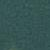

In [25]:
Image(filename=f"{data_dir}/water.jpg")

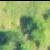

In [26]:
Image(filename=f"{data_dir}/field.jpg")

# Висновок

У даному завданні були взяті два різні види зображення(поле та вода). Ці дані були перетворені на вектори
фіч та розподілені на вибірки для тренування та навчання. Для навчання використовувався лінійний одношаровий персептрон. Модель вказаного программного класу була навчена методом ```fit```. Для класифікації був використаний метод ```predict``` із вказаного программного класу. Модель показала точність 50%. Можливими проблемами такої низької якості є: недостатня кількість епох навчання, не пудубрані гіперпараметри швидкості навчання та моменту, мала кількість реалізацій.